In [1]:
"""

PROD ALERT 2 CODE

Copyright © 2023 Dr Keith S Reid Cailleach Computing Ltd

keithreid@nhs.net

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated 
documentation files (the “Software”), to deal in the Software without restriction, including without limitation 
the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and 
to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions 
of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED 
TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL 
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER 
DEALINGS IN THE SOFTWARE.

"""

"""

From PROD-ALERT "1"
Institutions were categorised. “Small” were the continuous series of smallest institutions with “null” reports 
commensurate with size and having other monthly reports around 5 and 10. “Complete” institutions were bigger 
than “small” with one or less nulls. To interpolate single nulls among complete reporters, the last observation 
was carried forward, else next carried back (for month 1), both within the 12 months. Other institutions were 
neither small nor complete, and sub-categorised as “Partial”, “Joiner”, or “Null”.

By definition, “Joiners” consistently reported null then consistently reported restrained people – reporting none
then many. “Partial” reporter institutions had intermittent null but were not small enough to be in the 
continuous “small” series - reporting many people restrained then none then many, etc. “Null” report institutions
reported only null all year despite not being small – reporting none throughout while being the size of trusts 
reporting many. Small reporters with null restraints, and “joiner” or “partial” Bed-Day reporting style were 
categorised “null” – if bed counts were partial we did not trust restraint counts.

For PROD_ALERT-2
Small?
    Yes -> "SMALL"
    No  -> Full?
        Yes -> "FULL"
        No  -> drops one?
            Yes -> "CLOSE"
            No  -> Joins?
                Yes -> "JOINS"
                No  -> "PARTIAL" 


"""

"""
The author can provide sensitivity models, upon reasonable request.
Preferably readers may do their own, and can fork the code here.


     SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST average size 490.833333

beds 450 	510 	490 	480 	445 	450 	530 	525 	480 	510 	515 	505 
sect 10  	10  	10  	10  	10  	10  	10  	5   	10  	10  	10  	5


     EQUILIBRIUM HEALTHCARE                    average size 527.916667
     
beds 600 	650 	630 	650 	650 	500 	470 	450 	465 	435 	435 	400 
sect 20    	20  	20  	20  	20  	15  	15  	15  	15  	15  	15  	10

Due to visual inpection small for detentions is set at effectively 500.

These are small for detentions:

SCHOEN CLINIC YORK
GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST
ALDER HEY CHILDREN'S NHS FOUNDATION TRUST
TURNING POINT
NEWMARKET HOUSE HEALTHCARE LTD
WHITTINGTON HEALTH NHS TRUST
MANCHESTER UNIVERSITY NHS FOUNDATION TRUST
NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST
NEWBRIDGE CARE SYSTEMS LTD
BRAMLEY HEALTH
REGIS HEALTHCARE LIMITED
RIVERDALE GRANGE LIMITED
SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST



Due to visual inspection small for restraint is set at effectively 1011.

     ISLE OF WIGHT NHS TRUST                    average size 1011.250000
     
beds 990 	995 	1090 	1145 	1185 	920 	1075 	905 	1000 	915 	980 	935
sect 20  	30  	25  	25  	30  	30  	25  	30  	35  	20  	20  	20
rstr 5   	15  	15  	15  	15  	20  	20  	15  	15  	15  	10  	10

These are small for restraints:

SCHOEN CLINIC YORK
GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST
ALDER HEY CHILDREN'S NHS FOUNDATION TRUST
TURNING POINT
NEWMARKET HOUSE HEALTHCARE LTD
WHITTINGTON HEALTH NHS TRUST
MANCHESTER UNIVERSITY NHS FOUNDATION TRUST
NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST
NEWBRIDGE CARE SYSTEMS LTD
BRAMLEY HEALTH
REGIS HEALTHCARE LIMITED
RIVERDALE GRANGE LIMITED
SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST
EQUILIBRIUM HEALTHCARE
BIRMINGHAM WOMEN'S AND CHILDREN'S NHS FOUNDATION TRUST
DERBYSHIRE COMMUNITY HEALTH SERVICES NHS FOUNDATION TRUST
ACTIVE PATHWAYS
NEWBRIDGE CARE SYSTEMS
MAKING SPACE
ELLERN MEDE BARNET
CARETECH COMMUNITY SERVICES (NO.2) LIMITED
ISLE OF WIGHT NHS TRUST


"""
;

''

In [2]:
# libraries

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import warnings

warnings.filterwarnings('ignore')


In [3]:
# config
                                
pd.options.display.max_rows     = None
pd.options.display.max_columns  = None
plt.rcParams["figure.figsize"] = (20,10)

"""
We are specificaly naming files in development but will glob them later
"""

def get_beds_files():
    beds_files = ["beds01_Sep_2021.csv", "beds02_Oct_2021.csv", "beds03_Nov_2021.csv",
                  "beds04_Dec_2021.csv", "beds05_Jan_2022.csv", "beds06_Feb_2022.csv",
                  "beds07_Mar_2022.csv", "beds08_Apr_2022.csv", "beds09_May_2022.csv",
                  "beds10_Jun_2022.csv", "beds11_Jul_2022.csv", "beds12_Aug_2022.csv"]
    return beds_files

def get_rstr_files():
    rstr_files = ["rstr01_Sep_2021.csv", "rstr02_Oct_2021.csv", "rstr03_Nov_2021.csv",
                  "rstr04_Dec_2021.csv", "rstr05_Jan_2022.csv", "rstr06_Feb_2022.csv",
                  "rstr07_Mar_2022.csv", "rstr08_Apr_2022.csv", "rstr09_May_2022.csv",
                  "rstr10_Jun_2022.csv", "rstr11_Jul_2022.csv", "rstr12_Aug_2022.csv"]
    return rstr_files

def get_sect_files():
    rstr_files = ["sect01_Sep_2021.csv", "sect02_Oct_2021.csv", "sect03_Nov_2021.csv",
                  "sect04_Dec_2021.csv", "sect05_Jan_2022.csv", "sect06_Feb_2022.csv",
                  "sect07_Mar_2022.csv", "sect08_Apr_2022.csv", "sect09_May_2022.csv",
                  "sect10_Jun_2022.csv", "sect11_Jul_2022.csv", "sect12_Aug_2022.csv"]
    return rstr_files

def get_verbose():
    verbose = "No" # "Yes" or "No"
    return verbose

def get_small_for_rstr():
    get_small_for_rstr = ["SCHOEN CLINIC YORK",
                        "GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST",
                        "ALDER HEY CHILDREN'S NHS FOUNDATION TRUST",
                        "TURNING POINT",
                        "NEWMARKET HOUSE HEALTHCARE LTD",
                        "WHITTINGTON HEALTH NHS TRUST",
                        "MANCHESTER UNIVERSITY NHS FOUNDATION TRUST",
                        "NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST",
                        "NEWBRIDGE CARE SYSTEMS LTD",
                        "BRAMLEY HEALTH",
                        "REGIS HEALTHCARE LIMITED",
                        "RIVERDALE GRANGE LIMITED",
                        "SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST"]
    return get_small_for_rstr


def get_small_for_sect():
    small_for_sect = ["SCHOEN CLINIC YORK",
                        "GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST",
                        "ALDER HEY CHILDREN'S NHS FOUNDATION TRUST",
                        "TURNING POINT",
                        "NEWMARKET HOUSE HEALTHCARE LTD",
                        "WHITTINGTON HEALTH NHS TRUST",
                        "MANCHESTER UNIVERSITY NHS FOUNDATION TRUST",
                        "NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST",
                        "NEWBRIDGE CARE SYSTEMS LTD",
                        "BRAMLEY HEALTH",
                        "REGIS HEALTHCARE LIMITED",
                        "RIVERDALE GRANGE LIMITED",
                        "SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST",
                        "EQUILIBRIUM HEALTHCARE",
                        "BIRMINGHAM WOMEN'S AND CHILDREN'S NHS FOUNDATION TRUST",
                        "DERBYSHIRE COMMUNITY HEALTH SERVICES NHS FOUNDATION TRUST",
                        "ACTIVE PATHWAYS",
                        "NEWBRIDGE CARE SYSTEMS",
                        "MAKING SPACE",
                        "ELLERN MEDE BARNET",
                        "CARETECH COMMUNITY SERVICES (NO.2) LIMITED",
                        "ISLE OF WIGHT NHS TRUST"]
    return small_for_sect


In [4]:
# get data

def get_providers():
    beds_files              = get_beds_files()
    names_with_some_beds    = []
    for this_file in beds_files:
        df          = pd.read_csv(this_file, header=None)
        df.columns  = ["Month","Provider","Metric","Count"]
        for index, row in df.iterrows():
            if row["Count"] != "*":
                names_with_some_beds.append(row["Provider"])
    providers   = sorted(list(set(names_with_some_beds)))
    return providers

In [5]:
# build tables

def build_monthly_providers_beds(providers):
    beds_files              = get_beds_files()
    months                  = [x[0:10] for x in beds_files]
    monthly_providers_beds  = pd.DataFrame(columns = months, index = providers)
    for this_file in beds_files:
        month                       = this_file[0:10]
        monthly_bed_info            = pd.read_csv(this_file, header=None)
        monthly_bed_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_bed_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_beds.at[row["Provider"], month] = row["Count"]
                
    monthly_providers_beds.replace("*",   "0", inplace=True)
    monthly_providers_beds.fillna("0", inplace=True)
    return monthly_providers_beds

def build_monthly_providers_rstr(providers):
    rstr_files              = get_rstr_files()
    months                  = [x[0:10] for x in rstr_files]
    monthly_providers_rstr  = pd.DataFrame(columns = months, index = providers)
    for this_file in rstr_files:
        month                       = this_file[0:10]
        monthly_rstr_info            = pd.read_csv(this_file, header=None)
        monthly_rstr_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_rstr_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_rstr.at[row["Provider"], month] = row["Count"]
    monthly_providers_rstr.replace("*",   "0", inplace=True)
    monthly_providers_rstr.fillna("0", inplace=True)
    return monthly_providers_rstr

def build_monthly_providers_sect(providers):
    sect_files              = get_sect_files()
    months                  = [x[0:10] for x in sect_files]
    monthly_providers_sect  = pd.DataFrame(columns = months, index = providers)
    for this_file in sect_files:
        month                       = this_file[0:10]
        monthly_sect_info            = pd.read_csv(this_file, header=None)
        monthly_sect_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_sect_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_sect.at[row["Provider"], month] = row["Count"]
    monthly_providers_sect.replace("*",   "0", inplace=True)
    monthly_providers_sect.fillna("0", inplace=True)
    return monthly_providers_sect  

In [6]:
# maths model

def count_loglog_beds_rstr(log_main):
        small_for_rstr  = get_small_for_rstr()
        names_beds_rstr = []
        for index, row in log_main.iterrows():
            reported_beds = [row["beds01_Sep"], row["beds02_Oct"], row["beds03_Nov"],
                             row["beds04_Dec"], row["beds05_Jan"], row["beds06_Feb"],
                             row["beds07_Mar"], row["beds08_Apr"], row["beds09_May"],
                             row["beds10_Jun"], row["beds11_Jul"], row["beds12_Aug"]]
            reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                             row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                             row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                             row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
            
            if index in small_for_rstr:
                mean_beds       = np.mean(reported_beds)
                mean_rstr       = np.mean(reported_rstr)
                beds_rstr_point = ["SMALL", mean_beds, mean_rstr] #index
                names_beds_rstr.append(beds_rstr_point)
                plt.scatter(mean_beds, mean_rstr, color="orange")
            else:
                if reported_rstr == [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]:
                    clean_beds      = [x for x in reported_beds if x>0]
                    mean_beds       = np.mean(clean_beds)
                    mean_rstr       = 0.0
                    beds_rstr_point = ["NULL", mean_beds, mean_rstr] #index
                    names_beds_rstr.append(beds_rstr_point)
                    plt.scatter(mean_beds, mean_rstr, color="black")
                else:
                    if [x>0 for x in reported_rstr] == [True, True, True, True, True, True, True, True, True, True, True, True,]:
                        clean_beds      = [x for x in reported_beds if x>0]
                        clean_rstr      = [x for x in reported_rstr if x>0]
                        mean_beds       = np.mean(clean_beds)
                        mean_rstr       = np.mean(clean_rstr)
                        beds_rstr_point = ["FULL", mean_beds, mean_rstr] #index
                        names_beds_rstr.append(beds_rstr_point)
                        plt.scatter(mean_beds, mean_rstr, color="blue")
                    else:
                        if sum([int(y) for y in [x>0 for x in reported_rstr]]) == 11:
                            clean_beds      = [x for x in reported_beds if x>0]
                            clean_rstr      = [x for x in reported_rstr if x>0]
                            mean_beds       = np.mean(clean_beds)
                            mean_rstr       = np.mean(clean_rstr)
                            beds_rstr_point = ["CLOSE", mean_beds, mean_rstr] #index
                            names_beds_rstr.append(beds_rstr_point)
                            plt.scatter(mean_beds, mean_rstr, color="blue", alpha=0.5)
                        else:
                            if [[x>0 for x in reported_rstr][i-1]<=[x>0 for x in reported_rstr][i]
                                for i in list(range(1,12))] == [True, True, True, True, 
                                                                 True, True, True, True,
                                                                  True, True, True]:
                                clean_beds      = [x for x in reported_beds if x>0]
                                clean_rstr      = [x for x in reported_rstr if x>0]
                                mean_beds       = np.mean(clean_beds)
                                mean_rstr       = np.mean(clean_rstr)
                                beds_rstr_point = ["JOINS", mean_beds, mean_rstr] #index
                                names_beds_rstr.append(beds_rstr_point)
                                plt.scatter(mean_beds, mean_rstr, facecolor="white", edgecolor="black")
                            else:
                                clean_beds      = [x for x in reported_beds if x>0]
                                clean_rstr      = [x for x in reported_rstr if x>0]
                                mean_beds       = np.mean(clean_beds)
                                mean_rstr       = np.mean(clean_rstr)
                                beds_rstr_point = ["PARTIAL", mean_beds, mean_rstr] #index
                                clean_beds      = [x for x in reported_beds if x>0]
                                names_beds_rstr.append(beds_rstr_point)
                                plt.scatter(mean_beds, mean_rstr, color ="grey")
            
        plt.show()
        return names_beds_rstr

In [7]:
def count_loglog_sect_rstr(log_main):
        small_for_sect  = get_small_for_sect()
        names_sect_rstr = []
        for index, row in log_main.iterrows():
            reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                             row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                             row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                             row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
            reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                             row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                             row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                             row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
            
            if index in small_for_sect:
                mean_sect       = np.mean(reported_sect)
                mean_rstr       = np.mean(reported_rstr)
                sect_rstr_point = ["SMALL", mean_sect, mean_rstr] #index
                names_sect_rstr.append(sect_rstr_point)
                plt.scatter(mean_sect, mean_rstr, color="orange")
            else:
                if reported_rstr == [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]:
                    clean_sect      = [x for x in reported_sect if x>0]
                    mean_sect       = np.mean(clean_sect)
                    mean_rstr       = 0.0
                    sect_rstr_point = ["NULL", mean_sect, mean_rstr] #index
                    names_sect_rstr.append(sect_rstr_point)
                    plt.scatter(mean_sect, mean_rstr, color="black")
                else:
                    if [x>0 for x in reported_rstr] == [True, True, True, True, True, True, True, True, True, True, True, True,]:
                        clean_sect      = [x for x in reported_sect if x>0]
                        clean_rstr      = [x for x in reported_rstr if x>0]
                        mean_sect       = np.mean(clean_sect)
                        mean_rstr       = np.mean(clean_rstr)
                        sect_rstr_point = ["FULL", mean_sect, mean_rstr] #index
                        names_sect_rstr.append(sect_rstr_point)
                        plt.scatter(mean_sect, mean_rstr, color="blue")
                    else:
                        if sum([int(y) for y in [x>0 for x in reported_rstr]]) == 11:
                            clean_sect      = [x for x in reported_sect if x>0]
                            clean_rstr      = [x for x in reported_rstr if x>0]
                            mean_sect       = np.mean(clean_sect)
                            mean_rstr       = np.mean(clean_rstr)
                            sect_rstr_point = ["CLOSE", mean_sect, mean_rstr] #index
                            names_sect_rstr.append(sect_rstr_point)
                            plt.scatter(mean_sect, mean_rstr, color="blue", alpha=0.5)
                        else:
                            if [[x>0 for x in reported_rstr][i-1]<=[x>0 for x in reported_rstr][i]
                                for i in list(range(1,12))] == [True, True, True, True, 
                                                                 True, True, True, True,
                                                                  True, True, True]:
                                clean_sect      = [x for x in reported_sect if x>0]
                                clean_rstr      = [x for x in reported_rstr if x>0]
                                mean_sect       = np.mean(clean_sect)
                                mean_rstr       = np.mean(clean_rstr)
                                sect_rstr_point = ["JOINS", mean_sect, mean_rstr] #index
                                names_sect_rstr.append(sect_rstr_point)
                                plt.scatter(mean_sect, mean_rstr, facecolor="white", edgecolor="black")
                            else:
                                clean_sect      = [x for x in reported_sect if x>0]
                                clean_rstr      = [x for x in reported_rstr if x>0]
                                mean_sect       = np.mean(clean_sect)
                                mean_rstr       = np.mean(clean_rstr)
                                sect_rstr_point = ["PARTIAL", mean_sect, mean_rstr] #index 
                                clean_sect      = [x for x in reported_sect if x>0]
                                names_sect_rstr.append(sect_rstr_point)
                                plt.scatter(mean_sect, mean_rstr, color ="grey")
            
        plt.show()
        return names_sect_rstr

In [8]:
def order_providers_by_size(monthly_providers_beds):
        # returns NaN for all 0 but none should have that
        # no test - fell out of writing a higher function
        providers_by_size               = monthly_providers_beds.copy()
        providers_by_size               = providers_by_size.astype(int)
        providers_by_size["ProperMean"] = providers_by_size.mask(providers_by_size==0).mean(axis=1)
        providers_by_size               = providers_by_size.sort_values(by="ProperMean")
        providers_by_size               = providers_by_size.sort_values(by="ProperMean")
        providers_by_size.drop(["beds01_Sep","beds02_Oct","beds03_Nov",
                                "beds04_Dec","beds05_Jan","beds06_Feb",
                                "beds07_Mar","beds08_Apr","beds09_May",
                                "beds10_Jun","beds11_Jul","beds12_Aug"], axis=1, inplace=True)
        return providers_by_size

    

In [9]:
def laplace_correction_and_log(main_table):
    main_table  = main_table.astype(int)
    log_main    = main_table.transform(lambda x: np.log2(x+1))
    return log_main

In [10]:
# view

def greet():
    print("""Welcome to PROD ALERT 2.
     These results are not official do not read them.
     They have not yet been peer reviewed.
     This work is in development.
     The point is that the development will have been done openly, in retrospect, later.
     The underlying figures are already available at NHS Digital.
     
     Small?
     Yes -> "SMALL" : orange dots providers small enough for zeroes to occur plausibly
     No  -> Full?
        Yes -> "FULL" : dark blue dots providers which report twelve months of year
        No  -> drops one?
            Yes -> "CLOSE" : light blue dots providers which report eleven months of year
            No  -> Joins?
                Yes -> "JOINS" : white dots providers withh < 11 months who start and continue
                No  -> "PARTIAL" : grey dots providers withh < 11 months who start and stop
     """)
    
def maybe_tell_providers(providers_by_size):
    verbose = get_verbose()
    if verbose == "Yes":
        print("\nThese providers had some beds here they are in size of reported beds:\n")
        display(providers_by_size)

def maybe_tell_log_main(log_main):
    verbose = get_verbose()
    if verbose == "Yes":
        print("\nSize-ordered providers with reported bed-days, sectioned people and restrained people, transformed for scale:\n")
        display(log_main)

def maybe_tell_main_table(main_table):
    verbose = get_verbose()
    if verbose == "Yes":
        print("\nSize-ordered providers with reported bed-days, sectioned people and restrained people:\n")
        display(main_table)

def maybe_tell_monthly_providers_beds(monthly_providers_beds):
    verbose = get_verbose()
    if verbose == "Yes":
        print("""\nAlphabetic table of monthly providers and beds
                   * and empty are replaced with 0:\n""")
        display(monthly_providers_beds)
        
def maybe_tell_monthly_providers_rstr(monthly_providers_rstr):
    verbose = get_verbose()
    if verbose == "Yes":
        print("""\nAlphabetic table of monthly providers and reported people restrained per month
                   * and empty are replaced with 0:\n""")
        display(monthly_providers_rstr)
        
def maybe_tell_monthly_providers_sect(monthly_providers_sect):
    verbose = get_verbose()
    if verbose == "Yes":
        print("""\nAlphabetic table of monthly providers and reported people detained per month
                   * and empty are replaced with 0:\n""")
        display(monthly_providers_sect)

Welcome to PROD ALERT 2.
     These results are not official do not read them.
     They have not yet been peer reviewed.
     This work is in development.
     The point is that the development will have been done openly, in retrospect, later.
     The underlying figures are already available at NHS Digital.
     
     Small?
     Yes -> "SMALL" : orange dots providers small enough for zeroes to occur plausibly
     No  -> Full?
        Yes -> "FULL" : dark blue dots providers which report twelve months of year
        No  -> drops one?
            Yes -> "CLOSE" : light blue dots providers which report eleven months of year
            No  -> Joins?
                Yes -> "JOINS" : white dots providers withh < 11 months who start and continue
                No  -> "PARTIAL" : grey dots providers withh < 11 months who start and stop
     


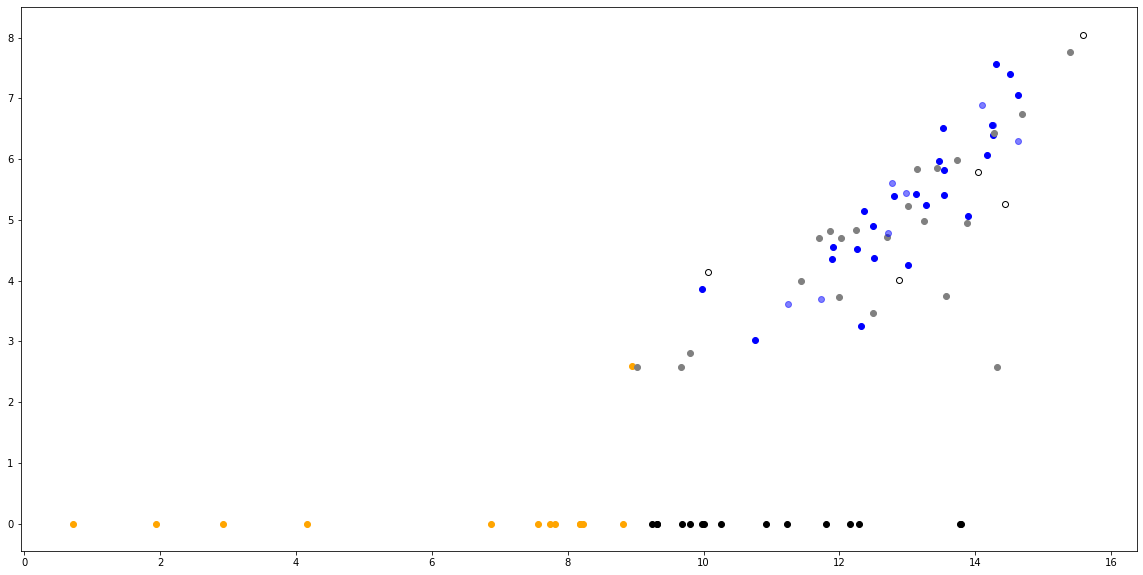

this explores log restraint as predicted by log beds


,0,1,2
0,SMALL,4.165854,0.000000
1,SMALL,7.564739,0.000000
2,SMALL,7.740704,0.000000
3,SMALL,1.943269,0.000000
4,SMALL,8.182090,0.000000
5,SMALL,8.232130,0.000000
6,SMALL,6.863486,0.000000
7,SMALL,8.174271,0.000000
8,SMALL,0.709642,0.000000
9,SMALL,7.806300,0.000000


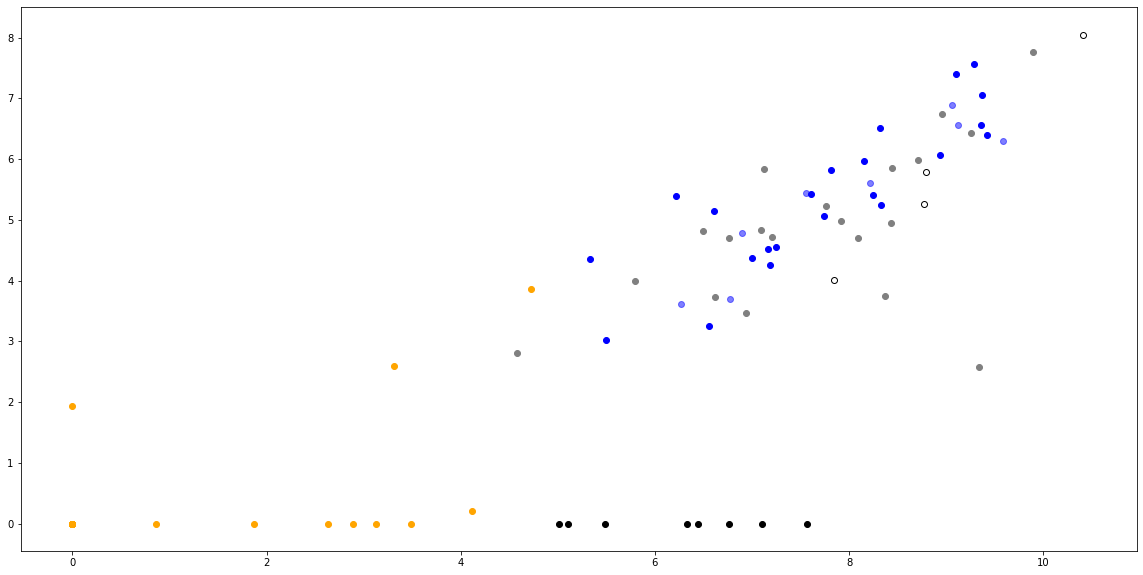

,0,1,2
0,SMALL,0.000000,0.000000
1,SMALL,0.000000,0.000000
2,SMALL,0.000000,0.000000
3,SMALL,0.000000,0.000000
4,SMALL,0.000000,0.000000
5,SMALL,0.000000,0.000000
6,SMALL,0.000000,0.000000
7,SMALL,2.629018,0.000000
8,SMALL,0.000000,0.000000
9,SMALL,0.000000,0.000000


In [11]:
# control

if __name__=="__main__":
                
    greet()
                            
    providers               = get_providers()
    monthly_providers_beds  = build_monthly_providers_beds(providers)
    monthly_providers_rstr  = build_monthly_providers_rstr(providers)
    monthly_providers_sect  = build_monthly_providers_sect(providers)
    ordered_providers       = order_providers_by_size(monthly_providers_beds)
    
    beds = pd.concat([ordered_providers,monthly_providers_beds], axis=1).reindex(ordered_providers.index)
    sect = pd.concat([beds,monthly_providers_sect], axis=1).reindex(beds.index)
    rstr = pd.concat([sect,monthly_providers_rstr], axis=1).reindex(sect.index)
                
    main_table  = rstr.copy()
    log_main    = laplace_correction_and_log(main_table)
    
    maybe_tell_providers(ordered_providers)
    maybe_tell_monthly_providers_beds(monthly_providers_beds)
    maybe_tell_monthly_providers_sect(monthly_providers_sect)
    maybe_tell_monthly_providers_rstr(monthly_providers_rstr)
    maybe_tell_main_table(main_table)
    maybe_tell_log_main(log_main)
                        
    loglog_beds_rstr    = count_loglog_beds_rstr(log_main)
    pretty_beds_rstr    = pd.DataFrame(loglog_beds_rstr)
    print("this explores log restraint as predicted by log beds")
    display(pretty_beds_rstr)
                        
    loglog_sect_rstr    = count_loglog_sect_rstr(log_main)
    pretty_sect_rstr    = pd.DataFrame(loglog_sect_rstr)
    display(pretty_sect_rstr)

In [12]:
# tests

def test_build_monthly_providers_beds():
    providers              = get_providers()
    monthly_providers_beds = build_monthly_providers_beds(providers)
    assert type(monthly_providers_beds)    == pd.DataFrame, "type test"
    assert type(monthly_providers_beds["beds01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","beds01_Sep"] == "19235", "correct value and type"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","beds01_Sep"] != 19235,   "correct value and type"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","beds01_Sep"] != "999",   "correct value and type"
    assert len(monthly_providers_beds)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_beds.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers beds")
    
def test_build_monthly_providers_rstr():
    providers              = get_providers()
    monthly_providers_rstr = build_monthly_providers_rstr(providers)
    assert type(monthly_providers_rstr)    == pd.DataFrame, "type test"
    assert type(monthly_providers_rstr["rstr01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","rstr01_Sep"] == "75", "correct value and type"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","rstr01_Sep"] != 75,   "correct value and type"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","rstr01_Sep"] != "999","correct value and type"  
    assert len(monthly_providers_rstr)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_rstr.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers rstr")
    
def test_build_monthly_providers_sect():
    providers              = get_providers()
    monthly_providers_sect = build_monthly_providers_sect(providers)
    assert type(monthly_providers_sect)    == pd.DataFrame, "type test"
    assert type(monthly_providers_sect["sect01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","sect01_Sep"] == "565", "correct value and type"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","sect01_Sep"] != 565,   "correct value and type"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","sect01_Sep"] != "999","correct value and type"  
    assert len(monthly_providers_sect)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_sect.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers sect")
    
def test_get_providers():
    providers = get_providers()
    assert type(providers)    == list, "type test"
    assert type(providers[1]) == str, "type test"
    assert len(providers)  == len(set(providers)), "uniqueness test"
    print("passed get providers")
    
def test_laplace_correction_and_log():
    toy         = {'Number':[4,3,2,1]}
    toy_df      = pd.DataFrame(toy)
    log_main    = laplace_correction_and_log(toy_df)
    assert list(log_main.Number) == [2.321928094887362, 2.0, 1.584962500721156, 1.0]    
    toy         = {'Jam':[4,3,2,1],'Spam':[15,31,63,0]}
    toy_df      = pd.DataFrame(toy)
    log_main    = laplace_correction_and_log(toy_df)
    assert list(log_main.Jam)  == [2.321928094887362, 2.0, 1.584962500721156, 1.0]
    assert list(log_main.Spam) == [4.0, 5.0, 6.0, 0.0]
    print("passed laplace correction and log")

def all_tests():
    test_build_monthly_providers_beds()
    test_build_monthly_providers_rstr()
    test_build_monthly_providers_sect()  
    test_get_providers()
    test_laplace_correction_and_log()
    print("passed all tests")
    
all_tests()    

passed build monthly providers beds
passed build monthly providers rstr
passed build monthly providers sect
passed get providers
passed laplace correction and log
passed all tests
